# Pull Request

Hello, NetworkX developers!

I'm Hiroki Hamaguchi from the University of Tokyo, Japan.
Today, We'd like to contribute to NetworkX by improving the `spring_layout` function.

Of course, we know that this function is a core feature of NetworkX, and thus we are very careful about the changes and willing to receive any feedbacks from the NetworkX community to refine our approach. We hope that our proposal will be beneficial to the NetworkX community.

## Abstract

We propose an improvement to the `spring_layout` function, which implements the Fruchterman–Reingold (FR) force-directed algorithm.

We leverages SciPy's efficient optimization algorithms to provide a simpler and faster approach to graph layout computation, based on [Hosobe, Hiroshi. "Numerical optimization-based graph drawing revisited." In 2012 IEEE Pacific Visualization Symposium, pp. 81-88. IEEE, 2012.](https://ieeexplore.ieee.org/iel5/6178307/6183555/06183577.pdf).

Our paper [Hamaguchi, Hiroki, Naoki Marumo, and Akiko Takeda. "Initial Placement for Fruchterman--Reingold Force Model with Coordinate Newton Direction." arXiv preprint arXiv:2412.20317 (2024).](https://arxiv.org/abs/2412.20317) also provides some explanation. If necessary, we can update this paper so that it explains our proposal more clearly.

#### Motivation
The current implementation of `spring_layout` has several limitations:
1. **Inefficient algorithm**: The existing approach does not fully utilize modern optimization techniques, leading to suboptimal performance and less aesthetically pleasing visualizations.
2. **Ill-defined FR-algorithm extension**: The current implementation extends the Fruchterman–Reingold algorithm in a way that can degrade visualization quality. Specifically, increasing the iteration count does not always lead to better results but can sometimes make the layout worse.

By leveraging SciPy’s optimization capabilities, we can address these issues while staying true to NetworkX’s core principles of correctness, readability, and efficiency.

#### Proposed Changes
- Replace the current force-directed approach with an optimization-based method using SciPy’s `optimize` module.
- Maintain API consistency by ensuring the function signature remains largely unchanged.
- Improve performance while simplifying the implementation.
- Ensure correctness and high-quality visualization output through rigorous testing and comparison.


[Mission and Values](https://networkx.org/documentation/stable/developer/values.html#mission-and-values)
- **Ease of use**: The new approach remains simple to use while improving layout quality.
- **Correctness**: We ensure well-defined behavior that aligns with the original algorithm’s intent.
- **Performance**: SciPy’s optimization tools provide a significant speed-up.
- **Readability**: The proposed implementation is clearer and more maintainable.
- **Education**: Thorough documentation and examples will be provided to help users understand the improvements.

#### Next Steps
We welcome feedback from the NetworkX community and are happy to refine our approach based on input from maintainers and contributors.



## Problem Formulation

Let $G = (V, E)$ be a graph with vertex set $V = \{1, \dots, n\}$ and edge set $E$.
Each edge $\{ i,j \} \in E$ has weight $a_{i,j}$, possibly negative.
For convenience, we set $a_{i,j}=0$ for $\{i, j\} \notin E$ and define $A \in \mathbb{R}^{n \times n}$ as the weight matrix of $G$.

The FR force model assumes forces between vertices.
For vertices $i$ and $j$ with a distance $d > 0$ between them, an attractive force $F_{i,j}^\mathrm{a}(d)$ and a repulsive force $F^\mathrm{r}(d)$ work as

$$
  F_{i,j}^\mathrm{a}(d) \coloneqq \frac{a_{i,j} d^2}{k}, \quad F^\mathrm{r}(d) \coloneqq -\frac{k^2}{d}
$$

where $k > 0$ is a constant parameter, often set to $1/\sqrt{n}$.

### Energy Function

The scalar potential of these forces~\cite{6183577} is given by

$$
\begin{gather*}
      E_{i,j}^\mathrm{a}(d) \coloneqq \int_{0}^{d} F_{i,j}^\mathrm{a}(r) \mathrm{d}{r} = \frac{a_{i,j} d^3}{3k}, \\
      E^\mathrm{r}(d)       \coloneqq \int_{\infty}^{d} F^\mathrm{r}(r) \mathrm{d}{r} = -k^2\log{d}, \\
      E_{i,j}(d)            \coloneqq E_{i,j}^\mathrm{a}(d) + E^\mathrm{r}(d).
\end{gather*}
$$

For simplicity, we define $E_{i,j}(0)=\infty$.
Let $\|\cdot\|$ denote the Euclidean norm in $\mathbb{R}^2$.
Then, the problem is to minimize the energy with $X \coloneqq (x_1, \dots, x_n)^\top \in \mathbb{R}^{n \times \mathrm{dim}}$:

$$
\begin{align*}
            \min_{X \in \mathbb{R}^{n \times \mathrm{dim}}} \quad f(X) \coloneqq &\sum_{i \neq j} \left( E_{i,j}(\|x_i - x_j\|) \right)\\
  =         {}& \sum_{i \neq j} \left( \frac{a_{i,j} \|x_i - x_j\|^3}{3k} - k^2\log{\|x_i - x_j\|} \right)\\
  =         {}& \sum_{i \neq j} \left((A \odot \mathrm{dist}^{\odot 3}) / (3k) - k^2 \log{\mathrm{dist}}\right)_{i,j} 
\end{align*}
$$

where

* $\mathrm{dist} \in \mathbb{R}^{n \times n}$ is defined as $\mathrm{dist}_{i,j} \coloneqq \|x_i - x_j\|$,
* $\odot$ denotes the Hadamard product,
* $\log$ in the last equation is the element-wise natural logarithm.


### Gradient of the Energy Function

Let us define $f_i$ as the sum of terms related to $x_i$:
$$
\begin{equation*}
  f_i(x_i) \coloneqq \sum_{j \in V \setminus \{i\}} \left( E_{i,j}(\|x_i - x_j\|) + E_{j,i}(\|x_j - x_i\|) \right).
\end{equation*}
$$

Then, the gradient of $f_i$ is given by

$$
\begin{align*}
  \nabla f_i(x_i) ={}& \sum_{j \in V \setminus \{i\}} \frac{(a_{i,j}+a_{j,i})\| x_i - x_j \|}{k} (x_i - x_j)\\
   & - \sum_{j \in V \setminus \{i\}} \frac{2k^2}{\| x_i - x_j \|^2} (x_i - x_j).
\end{align*}
$$

Thus, the gradient $\nabla f \in \mathbb{R}^{n \times \mathrm{dim}}$ is given by
$$
\begin{align*}
  \nabla f(X)_{i,z} &= \left(\nabla f_i(x_i)\right)_z\\
                    &= \sum_{j \in V \setminus \{i\}} \left(\frac{(a_{i,j}+a_{j,i})\| x_i - x_j \|}{k} - \frac{2k^2}{\| x_i - x_j \|^2}\right) (x_{i} - x_{j})_z\\
                    &= 2 \sum_{j \in V \setminus \{i\}} \left(\frac{\frac{a_{i,j}+a_{j,i}}{2}\| x_i - x_j \|}{k} - \frac{k^2}{\| x_i - x_j \|^2}\right) (x_{i} - x_{j})_z
\end{align*}
$$

<!-- We scale $X = (x_1, \dots, x_n)$ as $x_i \gets c x_i$ for all $i$.
This problem is to minimize $\phi(c)$:

$$
\begin{equation*}
  \phi(c) \coloneqq \left(\sum_{\{i,j\} \in E} \frac{a_{i,j} (c \| x_i - x_j \|)^3}{3k}\right) - k^2 \sum_{i < j} \log(c \|x_i - x_j\|)
\end{equation*}
$$

$\phi(c)$ is convex, and the optimal scaling factor $c^*$ by

$$
\begin{equation}
  c^* = \left(\frac{k^2 n(n-1)}{2 \sum_{\{i,j\} \in E} \frac{a_{i,j} \|x_i - x_j\|^3}{k}}\right)^{1/3}.
\end{equation}
$$ -->


In [16]:
import time
import scipy.optimize
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tqdm.auto as tqdm


# Copied from networkx.drawing.layout.py
def _sparse_fruchterman_reingold(
    A,
    k=None,
    pos=None,
    fixed=None,
    iterations=50,
    dim=2,
    verbose=False,
):
    # Position nodes in adjacency matrix A using Fruchterman-Reingold
    # Entry point for NetworkX graph is fruchterman_reingold_layout()
    # Sparse version
    import numpy as np
    import scipy as sp
    from scipy.optimize import minimize

    try:
        nnodes, _ = A.shape
    except AttributeError as err:
        msg = "fruchterman_reingold() takes an adjacency matrix as input"
        raise nx.NetworkXError(msg) from err

    if pos is None:
        # random initial positions
        pos = np.asarray(np.random.random((nnodes, dim)), dtype=A.dtype)
    else:
        # make sure positions are of same type as matrix
        pos = pos.astype(A.dtype)

    # no fixed nodes
    if fixed is None:
        fixed = []

    # optimal distance between nodes
    if k is None:
        k = np.sqrt(1.0 / nnodes)

    try:
        A = A.tolil()
    except AttributeError:
        A = (sp.sparse.coo_matrix(A)).tolil()

    A = np.abs(A)
    A = (A + A.T) / 2

    def cost_fun(x):
        pos = x.reshape((nnodes, dim))
        grad = np.zeros((nnodes, dim))
        cost = 0.0

        for i in range(0, nnodes, 100):
            i2 = min(i + 100, nnodes)  # 100 is the batch size
            delta = pos[i:i2][:, np.newaxis, :] - pos[np.newaxis, :, :]
            distance = np.linalg.norm(delta, axis=2)
            distance = np.maximum(distance, 0.01)
            grad[i:i2] = 2 * np.einsum(
                "ij,ijk->ik", A[i:i2] * distance / k - (k / distance) ** 2, delta
            )
            cost += np.sum(A[i:i2].multiply(distance**3)) / (3 * k)
            cost -= (k**2) * np.sum(np.log(distance + 1e-5))  # 1e-5 is to avoid log(0)

        norm_pos = np.linalg.norm(pos - 0.5, axis=1)
        mask = norm_pos > 1
        if np.any(mask):
            cost += 0.5 * np.sum((norm_pos[mask] - 1) ** 2)
            grad[mask] += (pos[mask] - 0.5) - (pos[mask] - 0.5) / norm_pos[mask][
                :, np.newaxis
            ]

        grad[fixed] = 0

        return cost, grad.ravel()

    res = minimize(
        cost_fun,
        pos.ravel(),
        method="L-BFGS-B",
        jac=True,
        options={"maxiter": iterations, "disp": verbose},
    )

    return res.x.reshape((nnodes, dim))

In [19]:
methods = [
    (nx.spring_layout, "tab:blue", []),
    (nx.spring_layout, "tab:blue", [None, None, None, 100]),  # 500 iterations
    (_sparse_fruchterman_reingold, "tab:orange", []),
    (_sparse_fruchterman_reingold, "tab:orange", [None, None, None, 100]),
    (nx.kamada_kawai_layout, "tab:green", []),
]


def makeFig(Gs):
    assert len(Gs) % 2 == 0
    n2 = len(Gs) // 2
    axes = plt.subplots(2 * len(methods), n2, figsize=(3 * n2, 3 * 2 * len(methods)))[1]
    axes = axes.flatten()

    progress = tqdm.tqdm(total=len(Gs) * len(methods))

    for i, (G, graphName) in enumerate(Gs):
        A = nx.to_scipy_sparse_array(G, dtype=np.float64)
        for j, (drawFunc, node_color, args) in enumerate(methods):
            ax = axes[i % n2 + j * n2 + len(methods) * n2 * int(i / n2)]

            t0 = time.perf_counter()
            try:
                pos = drawFunc(A if j in [2, 3] else G, *args)
            except ValueError:
                # kamada_kawai_layout does not support negative edge weights
                pos = np.zeros((len(G), 2))
            t1 = time.perf_counter()

            if type(pos) == np.ndarray:
                nodes = G.nodes()
                pos = dict(zip(nodes, pos))

            if j == 0:
                ax.set_title(f"{graphName}\n{t1 - t0:.2f}s", fontsize=15)
            else:
                ax.set_title(f"{t1 - t0:.2f}s", fontsize=15)

            nx.draw(G, pos=pos, ax=ax, node_size=50, node_color=node_color)
            ax.axis("on")
            progress.update(1)

    plt.tight_layout()
    plt.show()

  0%|          | 0/90 [00:00<?, ?it/s]

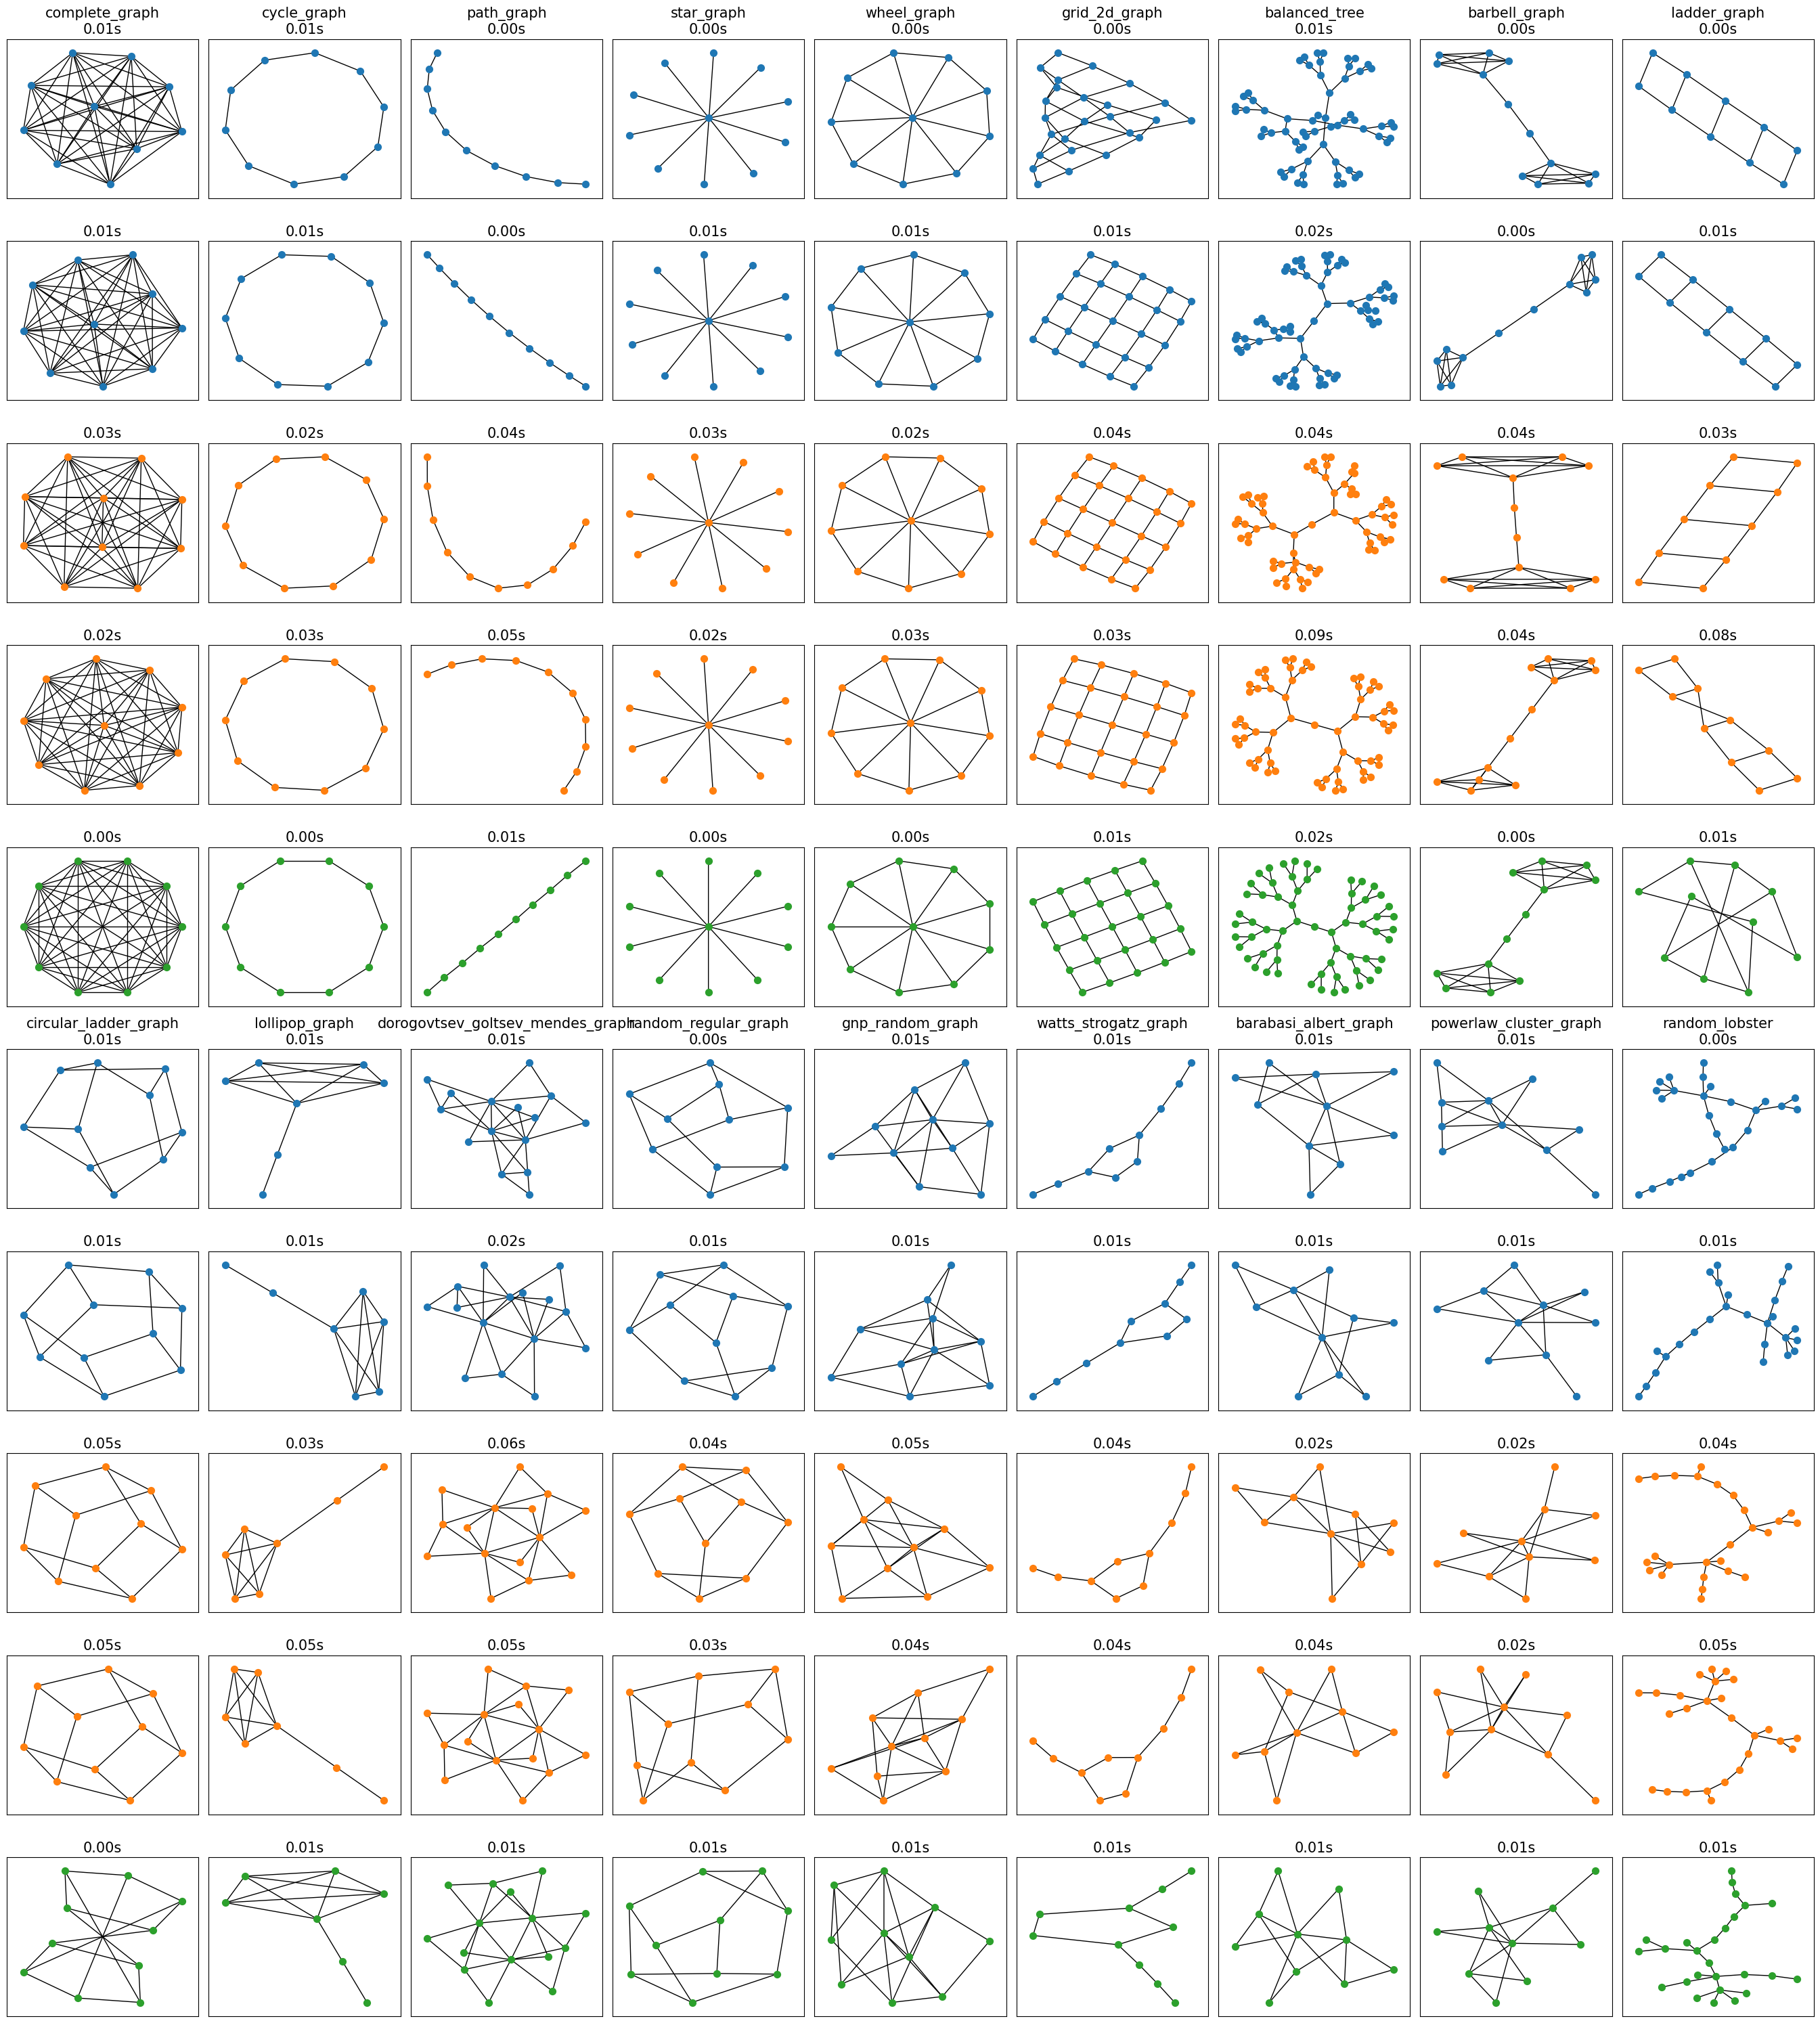

  0%|          | 0/90 [00:00<?, ?it/s]

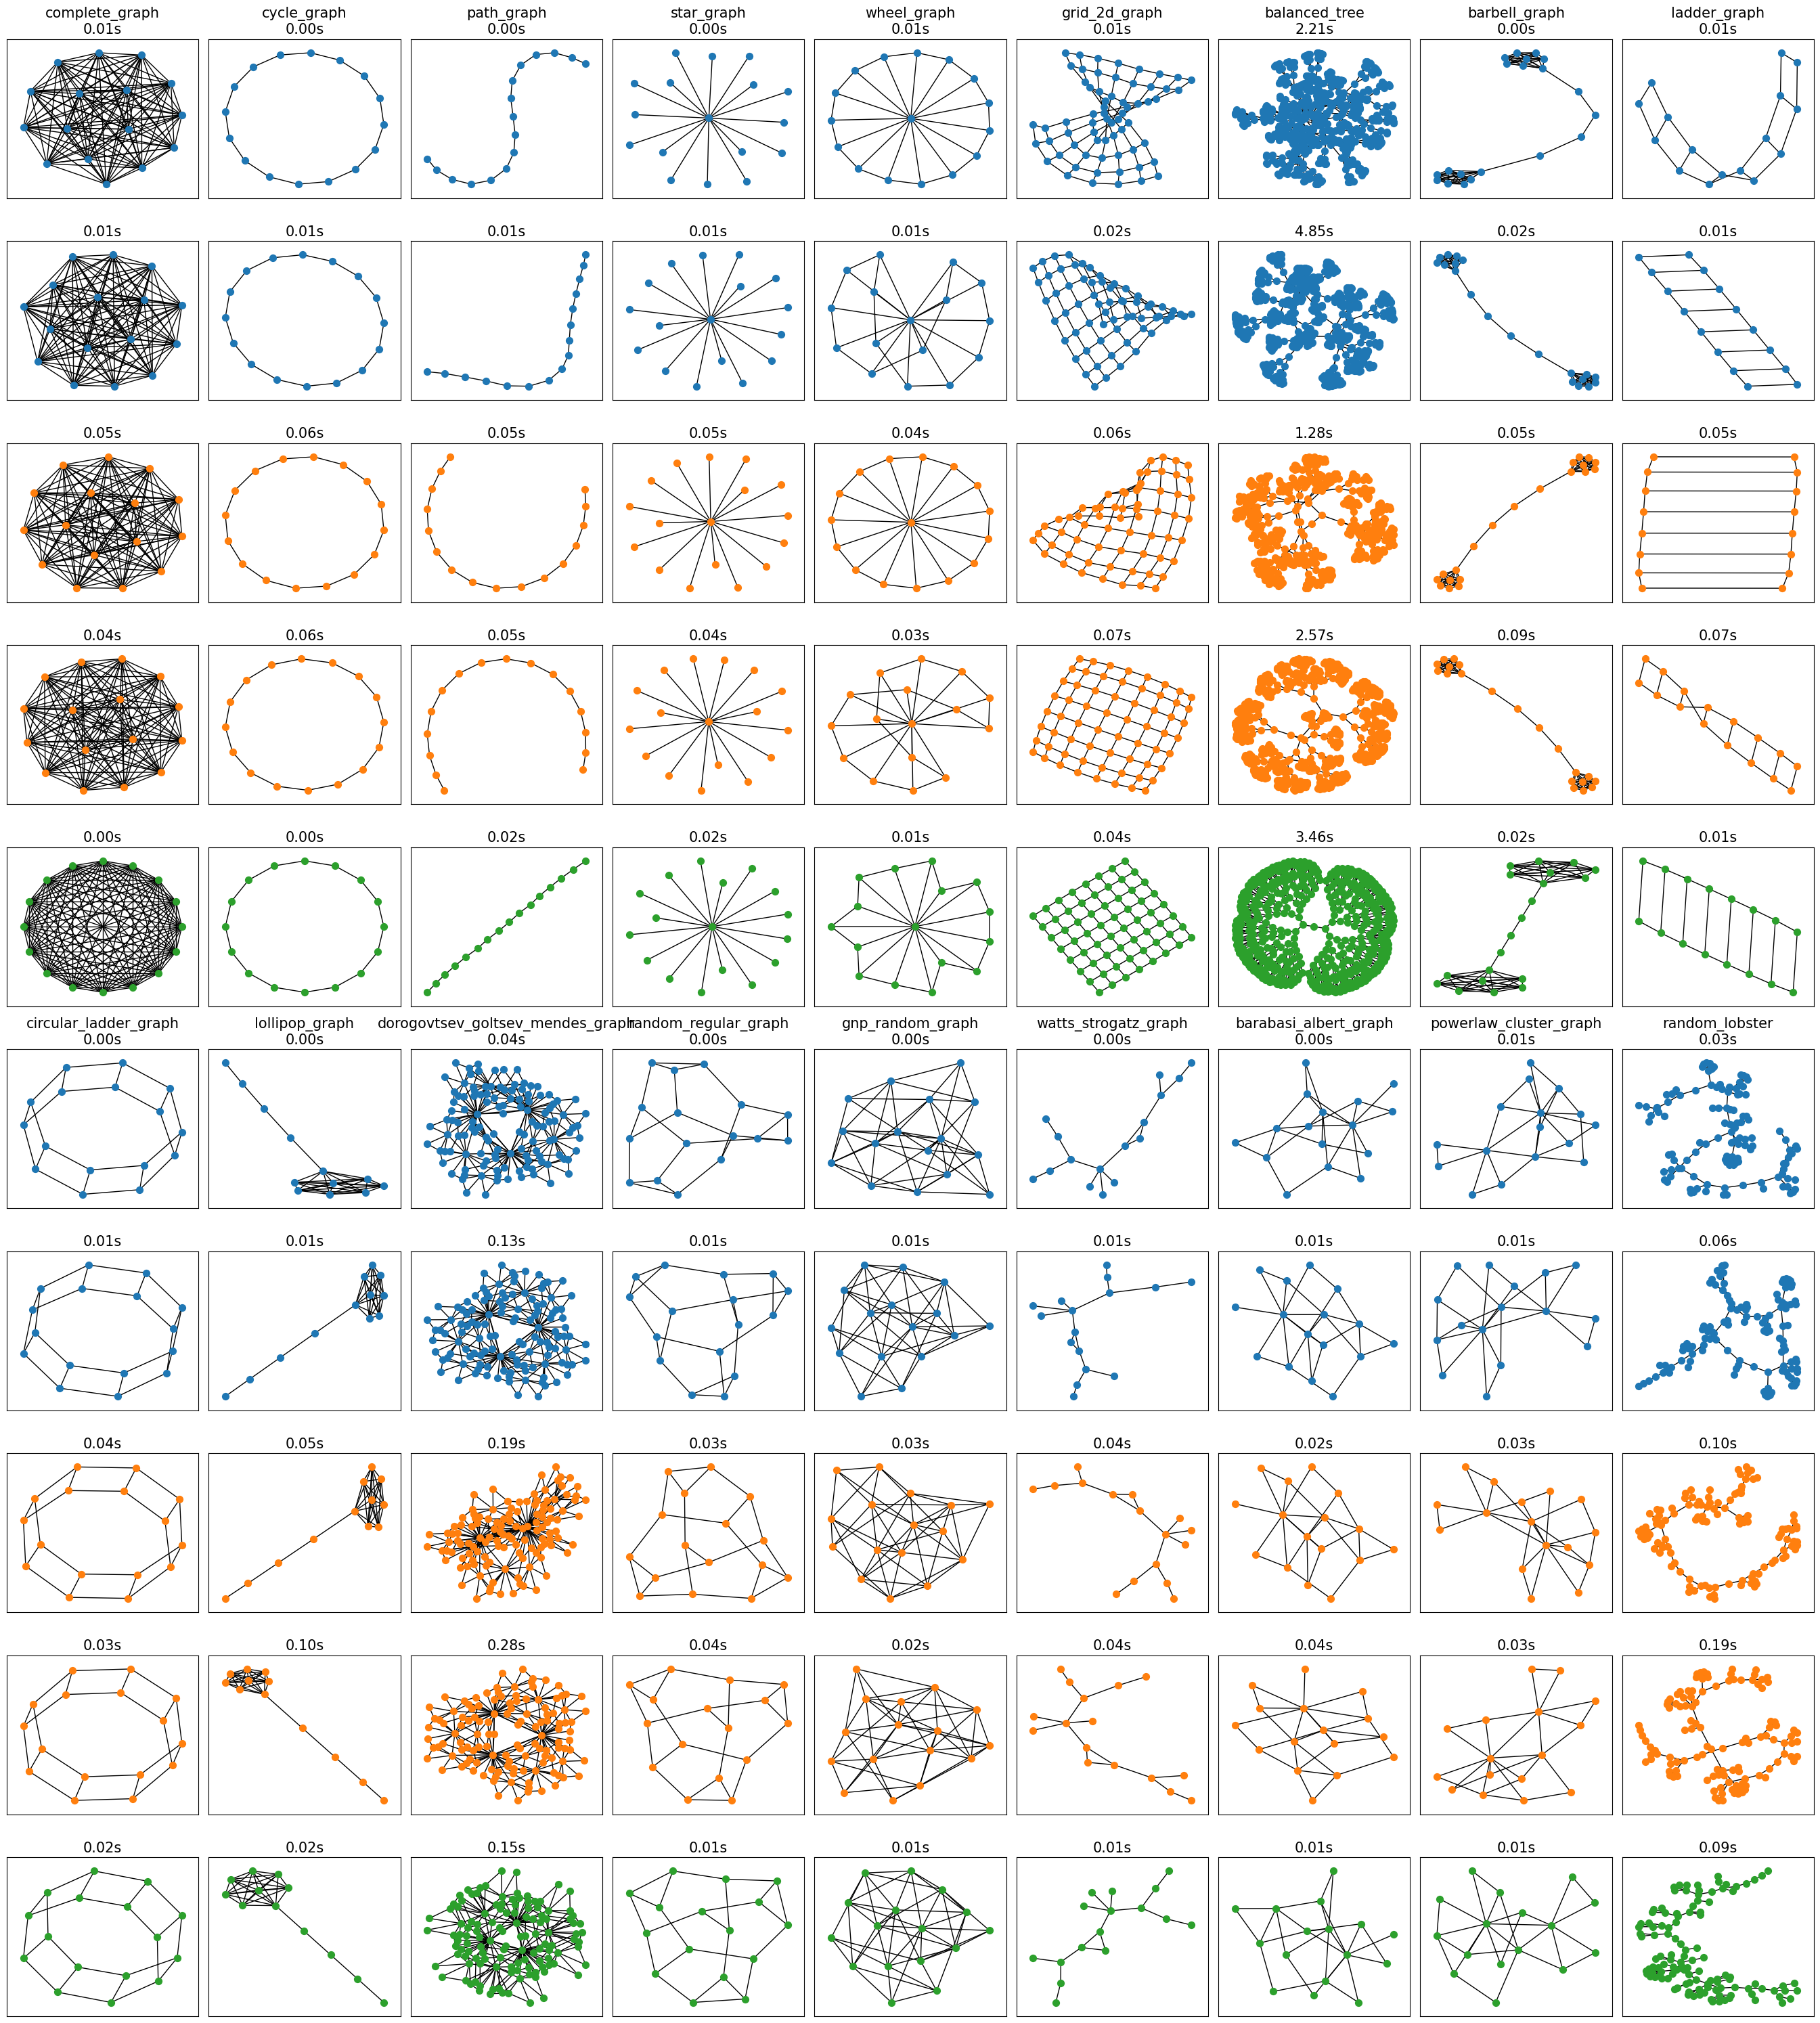

In [20]:
def graph_generator(n: int):
    graph_functions = [
        # Complete graph
        # Parameters: n (number of nodes)
        (nx.complete_graph, [n]),
        # Cycle graph
        # Parameters: n (number of nodes)
        (nx.cycle_graph, [n]),
        # Path graph
        # Parameters: n (number of nodes)
        (nx.path_graph, [n]),
        # Star graph
        # Parameters: n (number of nodes)
        (nx.star_graph, [n]),
        # Wheel graph
        # Parameters: n (number of nodes)
        (nx.wheel_graph, [n]),
        # 2D Grid graph
        # Parameters: m (number of rows), n (number of columns)
        (nx.grid_2d_graph, [int(n / 2), int(n / 2)]),
        # Balanced tree
        # Parameters: r (branching factor), h (height)
        (nx.balanced_tree, [2, int(n / 2)]),
        # Barbell graph
        # Parameters: m1 (number of nodes in each complete graph), m2 (number of nodes in the path)
        (nx.barbell_graph, [int(n / 2), int(n / 4)]),
        # Ladder graph
        # Parameters: n (number of rungs)
        (nx.ladder_graph, [int(n / 2)]),
        # Circular ladder graph
        # Parameters: n (number of rungs)
        (nx.circular_ladder_graph, [int(n / 2)]),
        # Lollipop graph
        # Parameters: m (number of nodes in the complete graph), n (number of nodes in the path)
        (nx.lollipop_graph, [int(n / 2), int(n / 4)]),
        # Dorogovtsev-Goltsev-Mendes graph
        # Parameters: n (number of nodes)
        (nx.dorogovtsev_goltsev_mendes_graph, [int(n / 3)]),
        # Random regular graph
        # Parameters: d (degree), n (number of nodes)
        (nx.random_regular_graph, [3, n]),
        # Erdos-Renyi graph
        # Parameters: n (number of nodes), p (probability of edge creation)
        (nx.erdos_renyi_graph, [n, 0.5]),
        # Watts-Strogatz graph
        # Parameters: n (number of nodes), k (each node is joined with its k nearest neighbors), p (rewiring probability)
        (nx.watts_strogatz_graph, [n, 2, 0.5]),
        # Barabasi-Albert graph
        # Parameters: n (number of nodes), m (number of edges to attach from a new node to existing nodes)
        (nx.barabasi_albert_graph, [n, 2]),
        # Powerlaw cluster graph
        # Parameters: n (number of nodes), m (number of random edges to add for each new node), p (probability of adding a triangle after adding a random edge)
        (nx.powerlaw_cluster_graph, [n, 2, 0.5]),
        # Random lobster graph
        # Parameters: n (number of nodes), p1 (probability of adding an edge to the backbone), p2 (probability of adding an edge to the tail)
        (nx.random_lobster, [n, 0.5, 0.5]),
    ]
    return [(func(*args), func.__name__) for func, args in graph_functions]


makeFig(graph_generator(10))

makeFig(graph_generator(16))

## Validation

  0%|          | 0/50 [00:00<?, ?it/s]

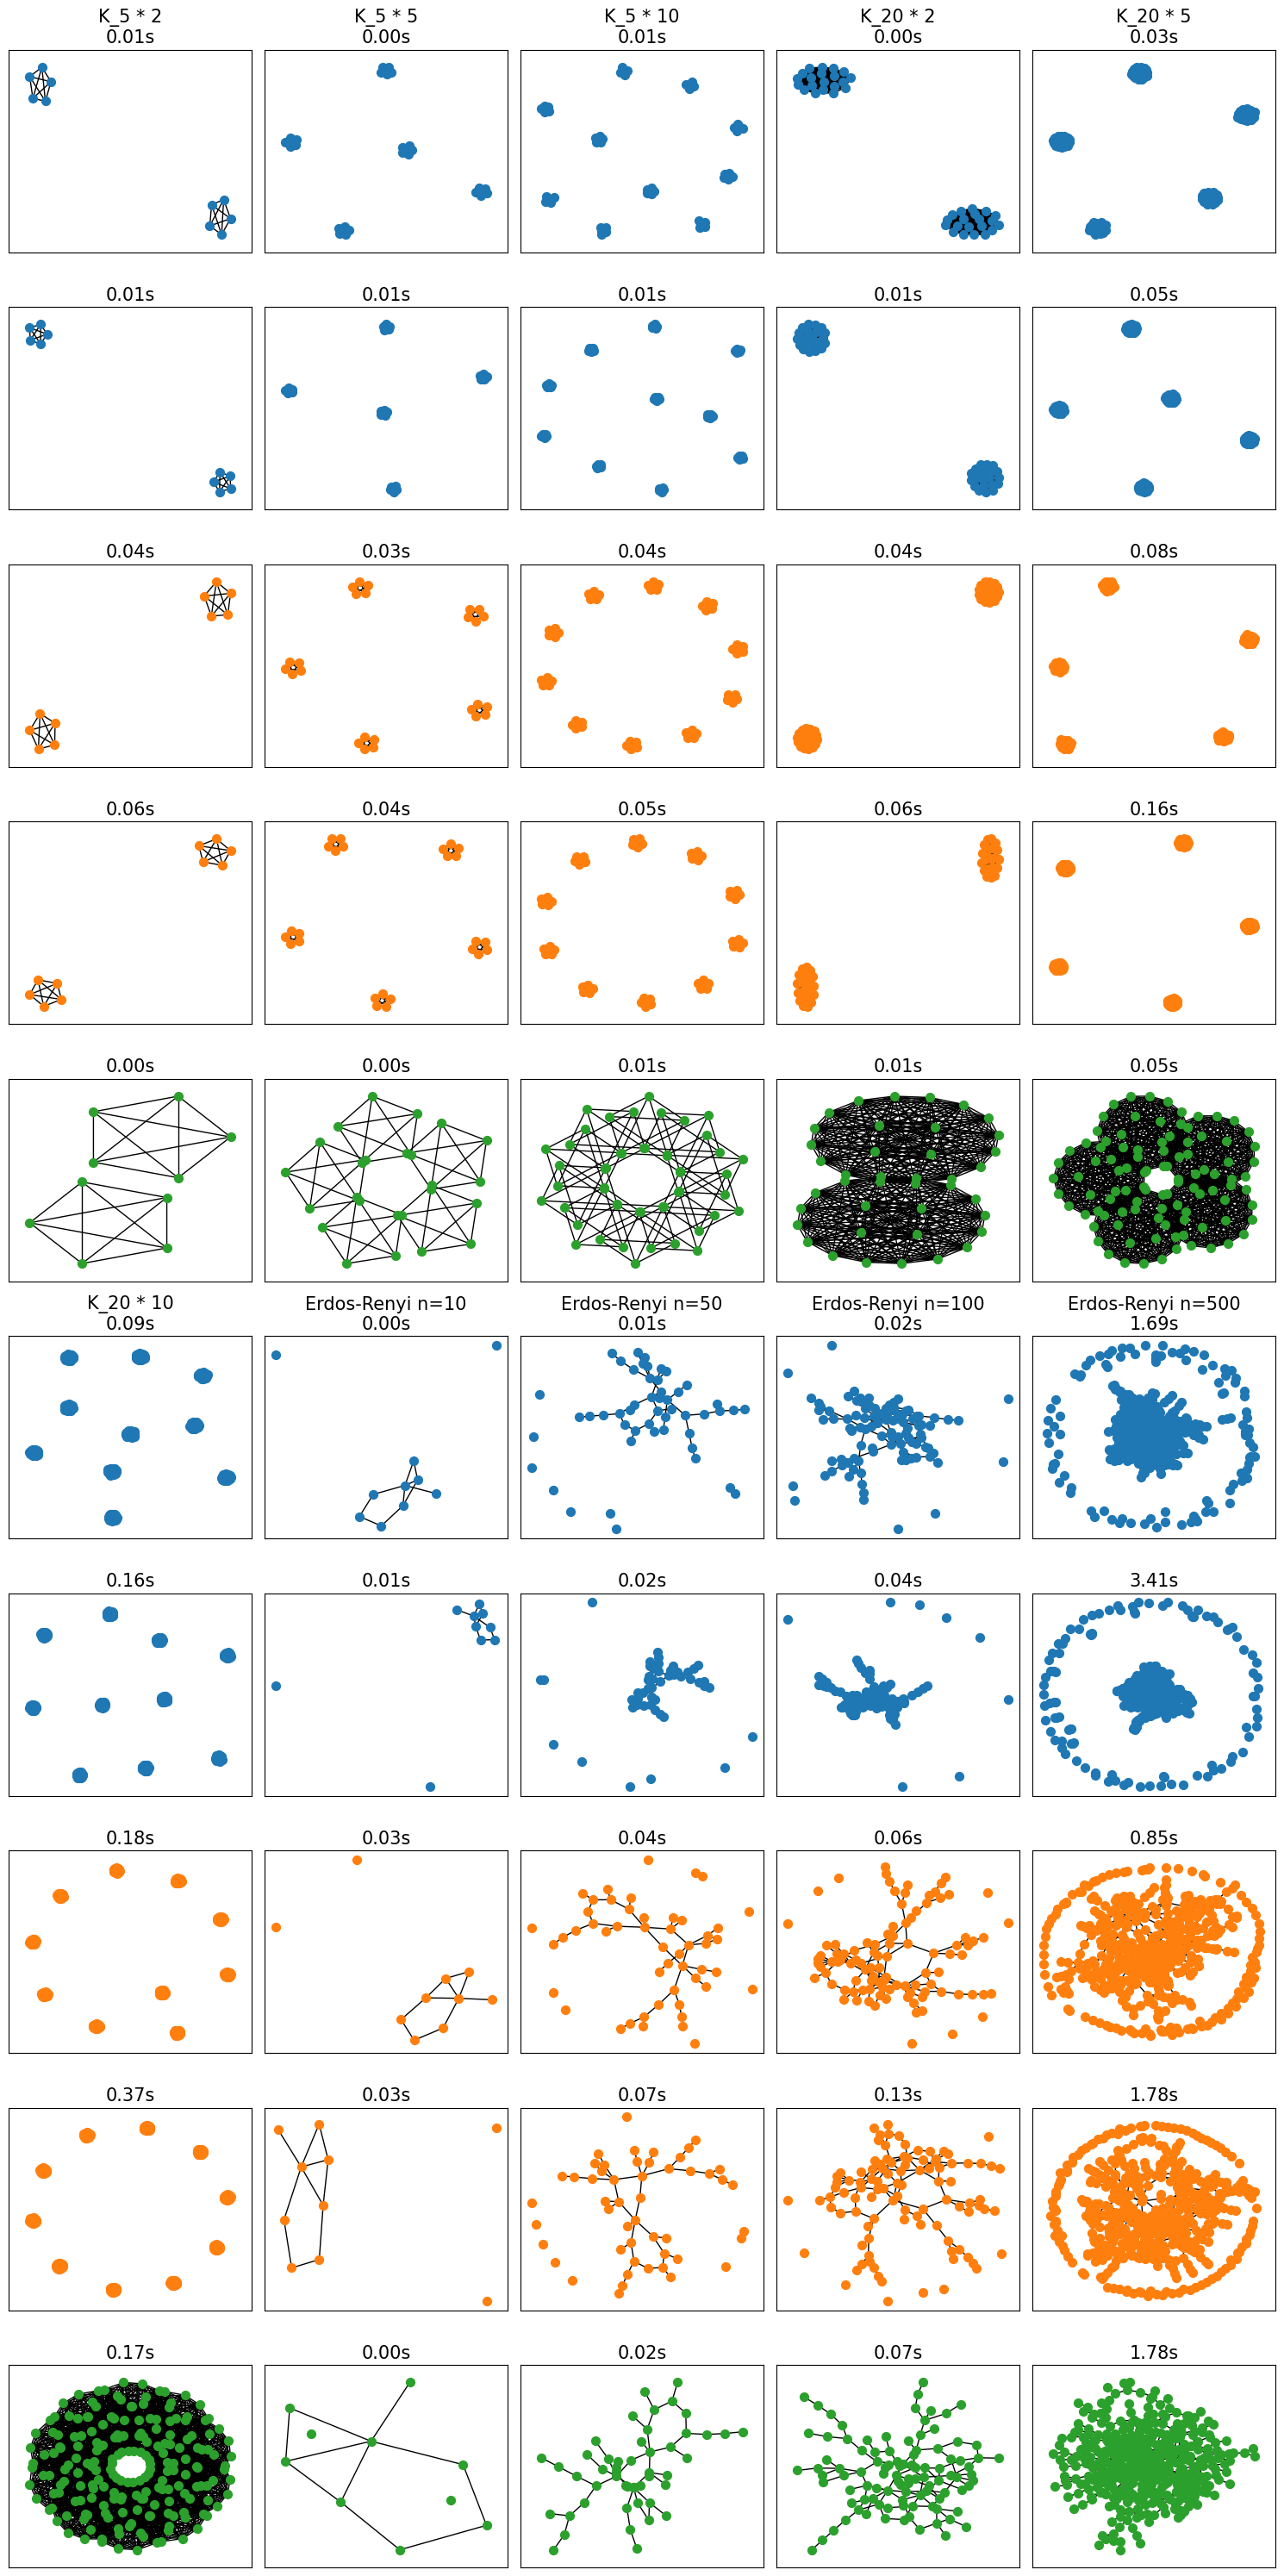

In [21]:
def separated_graphs():
    def create_and_draw_graphs(n, m):
        graphs = [nx.complete_graph(n) for _ in range(m)]
        G = nx.disjoint_union_all(graphs)
        return G

    Gs = []
    for n in [5, 20]:
        for m in [2, 5, 10]:
            Gs.append((create_and_draw_graphs(n, m), f"K_{n} * {m}"))
    for n in [10, 50, 100, 500]:
        Gs.append((nx.erdos_renyi_graph(n, 2 / n), f"Erdos-Renyi n={n}"))

    return Gs


makeFig(separated_graphs())

In [ ]:
import scipy.io
import ssgetpy

# https://arxiv.org/abs/1710.04626
matrixes = [
    ssgetpy.search(name)
    for name in [
        "1138_bus",
        "dwt_1005",
        "poli",
        "dwt_2680",
        "USPowerGrid",
        "3elt",
    ]
]

Gs = []
for mat in matrixes:
    mat = mat[0]
    path = mat.download(extract=True)[0]
    A = scipy.io.mmread(path + f"/{mat.name}.mtx")
    G = nx.from_scipy_sparse_array(A)
    Gs.append((G, mat.name))

makeFig(Gs)

AssertionError: 